# Introduction

## What is introgression

Introgression is the phenomenon that genetic materials move from one lineage into another lineage between two different species.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b8/Homo_sapiens_lineage.svg/1200px-Homo_sapiens_lineage.svg.png" alt="human_introgression" width="500"/>

**Figure 1 Interbreeding between archaic and modern humans.** This figure is from https://en.wikipedia.org/wiki/Interbreeding_between_archaic_and_modern_humans.

## Strategies for identifying introgressed regions

There are two major strategies to indentify introgressed regions.
1. If we have genomes from source populations, for example, genomes from Neanderthals, we can compare modern human genomes with Neanderthal genomes directly.
2. If we do not have source genomes, for example, we want to indentify introgression from an unknown lineage (ghost introgression), we can apply some statistical models to find out unusal regions.

Several tools can identify introgression without source populations.
- [SkovHMM](https://github.com/LauritsSkov/Introgression-detection)
- [sstar](https://github.com/admixVIE/sstar)
- [SPrime](https://github.com/browning-lab/sprime)

Here, we will try **sstar**, one of the available tools for this purpose.

There is extensive documentation here: https://sstar.readthedocs.io/en/latest/

## Install sstar

The very first thing: install it through the command line!

```
export LD_LIBRARY_PATH=/usr/local/lib/R/lib:$LD_LIBRARY_PATH

pip install sstar
```

And get the data:
```
mkdir ~/notebooks/introgression/data/
cd ~/notebooks/introgression/data/

wget https://ucloud.univie.ac.at/index.php/s/sjVDEgg2KDvI9u8/download

tar -zxvf download
```

This is the same vcf file used in the first Challenge session. That means, we want to make sure there are no missing data in our dataset. We already know how to do that:

```
bcftools view --exclude 'GT="./."' testset.filtered.vcf.gz | bgzip > testset.filtered.nomis.vcf.gz
```


## What is sstar?

The S* statistic has been used first to describe deep human population structure, then to suggest Neanderthal introgression **before** the Neanderthal genome was sequenced, then to infer the introgression landscape of Neanderthal and Denisovan introgression in modern humans.

It measures, to put it simply, the amount of private variation (compared to an outgroup population) in close proximity:

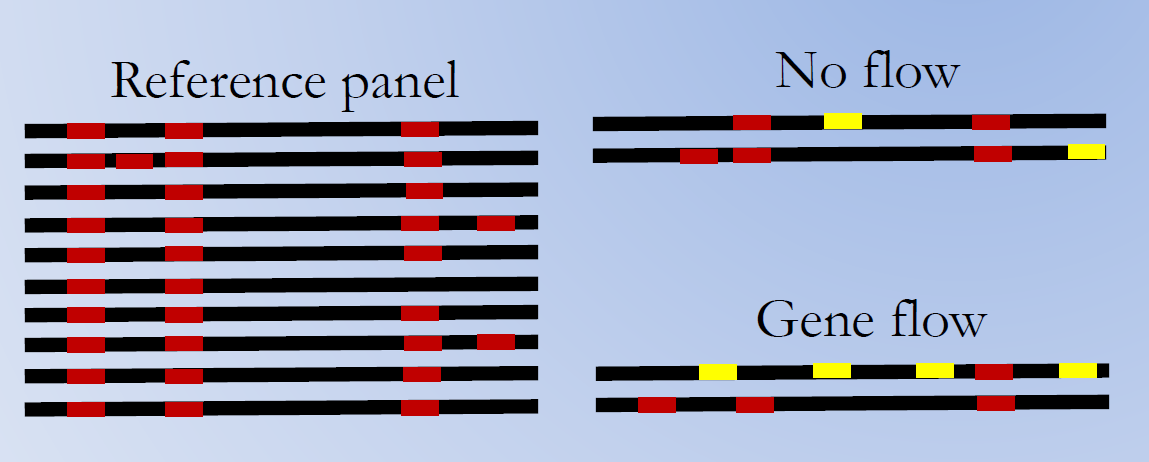

**sstar** is a tool to use this statistic on a set of genomes (here is the paper: https://doi.org/10.1093/molbev/msac212). It is a python package to use S* for getting introgressed pieces of the genome.

To do this, several steps are performed.

* First, the S* statistic is calculated in small windows along the genome.

* Second, based on a demographic model, the expected S* scores for this population.

* Third, significance is assessed.

* Fourth, the introgressed fragments are defined.

* An optional fifth step, in case you have one or two possible source genomes, is to calculate the match to these sources.


## Calculating S* scores

The scores cal be calculated with the function `sstar score`, and defined lists of individuals that are the "Reference panel" (no introgression) and the "Target panel" (potentially introgression). Check the two lists, then apply the function.

```
sstar score --vcf testset.filtered.nomis.vcf.gz --ref ref.ind.list --tgt tgt.ind.list --output test.score.results
```

This is the most basic command, but there are parameters to change.

Now we inspect the score.results table!


In [ ]:
## Using a demographic model to know what is significant


In [ ]:
## applying the threshold


In [1]:
## Calculating the match to a source population


In [ ]:
## Get the introgressed tracts